In [ ]:
import numpy as np
import os
import sys
from pprint import pprint
from numpy import sin, cos, pi
import numpy.matlib
import random
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point
import shapely.affinity as affinity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import pyomo.environ as pyo
import pyomo.gdp as pyg
from scipy.spatial import ConvexHull
#tf.disable_v2_behavior()  # this line is added to allow placeholder() function to work (does not work in tf2)

2022-01-19 14:57:44.498743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/daittan/catkin_ws/devel/lib:/opt/ros/melodic/lib:/home/daittan/NN-Repair/gurobi912/linux64/lib
2022-01-19 14:57:44.498769: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#  Generate Data


## Training/Testing Data 

#### Create Data (Affine Transformation)

In [ ]:
num_pts = 200
## polygon vertices
poly = Polygon([(1, 1), (4, 1), (4, 4), (1, 4)])
poly2 = Polygon([(2.5, 4.621), (4.624, 2.5), (2.5, 0.3787), (0.3787, 2.5)])  # transformed polygon vertices
x_poly, y_poly = poly.exterior.xy
x_poly2, y_poly2 = poly2.exterior.xy

In [ ]:
## generate random points within the input polygon
def random_points_within(pol, num_points):
    min_x, min_y, max_x, max_y = pol.bounds

    gen_points = []

    while len(gen_points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if random_point.within(pol):
            gen_points.append(random_point)

    return gen_points

points_obj = random_points_within(poly, num_pts)
x = np.ones((3, num_pts))     #(x,y,b)

for i in range(num_pts):
    x[0][i] = points_obj[i].x
    x[1][i] = points_obj[i].y


In [ ]:
## rotate input points in-place by pi/4 radian
transform1 = np.array([[1, 0, 2.5], [0, 1, 2.5], [0, 0, 1]])  # transformation matrix 1
transform2 = np.array([[1, 0, -2.5], [0, 1, -2.5], [0, 0, 1]])  # transformation matrix 2
rotate = np.array([[cos(pi / 4), -sin(pi / 4), 0], [sin(pi / 4), cos(pi / 4), 0], [0, 0, 1]])  # rotation matrix
y = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), x)

#### Safe Bound

In [ ]:
inp = np.array([[1.25, 3.75, 3.75, 1.25],[1.25, 1.25, 3.75, 3.75],[1, 1 , 1, 1]])
out = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), inp)
poly3 = Polygon([(out[0, 0], out[1, 0]), (out[0, 1], out[1, 1]), (out[0, 2], out[1, 2]), (out[0, 3], out[1, 3])])

# get the coordinates of the exterior points of the polytope
ex_points = np.array(poly3.exterior.coords)

# get A and b matrices
hull = ConvexHull(ex_points)
eqs = np.array(hull.equations)
A = eqs[0:eqs.shape[0],0:eqs.shape[1]-1]
b = -eqs[0:eqs.shape[0],-1]
print(A)
print(b)
print(ex_points)

[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
[ 1.25        4.78553391 -2.28553391  1.25      ]
[[2.5        0.73223305]
 [4.26776695 2.5       ]
 [2.5        4.26776695]
 [0.73223305 2.5       ]
 [2.5        0.73223305]]


#### Plot the Genarated Data 

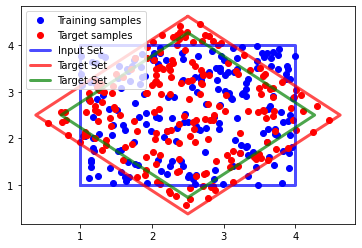

In [ ]:
## plot generated data
x_poly3, y_poly3 = poly3.exterior.xy
plt.plot(x[0, :], x[1, :], 'bo', label='Training samples')
plt.plot(y[0, :], y[1, :], 'ro', label='Target samples')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(x_poly2, y_poly2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.legend(loc="upper left")
plt.show()

## reshape input and outputs into column vectors
#x = np.transpose(x[[0, 1], :])
#y = np.transpose(y[[0, 1], :])
x = np.transpose(x)
y = np.transpose(y)

#### Generate data points around the edge

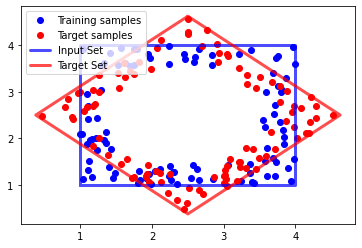

In [ ]:
def random_points_edge(poly, num_points, scale = 0.7):
    poly_a = affinity.scale(poly, xfact = scale, yfact = scale)
    gen_points = []
    while len(gen_points) < num_points:
        temp = random_points_within(poly, 1)
        if not temp[0].within(poly_a):
            gen_points.append(temp[0])
    return gen_points

num_points_edge = 100
points_edge = random_points_edge(poly, num_points_edge)
x_edge = np.ones((3, num_points_edge))     #(x,y,b)

for i in range(num_points_edge):
    x_edge[0][i] = points_edge[i].x
    x_edge[1][i] = points_edge[i].y

## rotate input points in-place by pi/4 radian
y_edge = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), x_edge)
    
## plot generated data
plt.plot(x_edge[0, :], x_edge[1, :], 'bo', label='Training samples')
plt.plot(y_edge[0, :], y_edge[1, :], 'ro', label='Target samples')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(x_poly2, y_poly2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.legend(loc="upper left")
plt.show()
x_edge = np.transpose(x_edge)
y_edge = np.transpose(y_edge)

In [ ]:
x = np.append(x, x_edge,axis = 0)
y = np.append(y, y_edge,axis = 0)

#### Training Mini-Batch Generator

In [ ]:
print(x.shape)

(300, 3)


In [ ]:
class Batch(object):
    def __init__(self, X_col, Y_col, batch_size_val):
        self.X = X_col
        self.Y = Y_col
        self.size = X_col.shape[0]
        self.train_size = batch_size_val
        self.test_size = self.size - batch_size_val

    def getBatch(self):
        values = range(self.size)
        train_dataset, test_dataset = train_test_split(values, train_size=self.train_size, test_size=self.test_size)
        # indices = np.random.choice(range(self.size), self.batch_size)  # sampling with replacement
        return self.X[train_dataset, :], self.Y[train_dataset, :], self.X[test_dataset, :], self.Y[test_dataset, :]
num_pts = x.shape[0]
batch_size = int(0.7 * num_pts)
batch = Batch(x, y, batch_size)

In [ ]:
batch_size

210

# 3-Layer NN

## Build 3-Layer NN Model

Here we setup a 3-layer MLP, with the single hidden layer of ReLU activation and train it with gradient descent optimizer to learn the defined affine transformation from the given data. 
$$
\min_{\mathbf{W}^0,\mathbf{W}^1,\mathbf{W}^2,\mathbf{b}^0,\mathbf{b}^1,\mathbf{b}^2}~~\frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{W}^1,\mathbf{b}^0,\mathbf{b}^1)-\mathbf{t}_n||^2_2
$$
$$
\mathbf{W}^0 \mathbf{x}^0 + \mathbf{b}^0 = \mathbf{h}^0
$$
$$
\mathbf{x}^1 = \mathrm{ReLU} (\mathbf{h}^0)
$$
$$
\mathbf{W}^1 \mathbf{x}^1 + \mathbf{b}^1 = \mathbf{h}^1
$$
$$
\mathbf{x}^2 = \mathrm{ReLU} (\mathbf{h}^1)
$$
$$
\mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y}
$$

![NN_original.jpg](NN_original.jpg)


#### Initializing Parameters for MLP Model

In [ ]:
num_input = batch.X.shape[1]
num_output = batch.Y.shape[1]
#num_layers_0 = 3
num_hidden_0 = 20
num_hidden_1 = 10
architecture = [num_input, num_hidden_0, num_hidden_1, num_output]
starter_learning_rate = 0.01
regularizer_rate = 0.001

#Create the 3 layers model
# Define Sequential model with 3 layers
model_orig = keras.Sequential(name="3_layer_NN")
model_orig.add(layers.Dense(num_hidden_0,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            input_shape=(3,),
                            name="layer0"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_hidden_1,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            name="layer1"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_output,
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate), 
                            name="output"))

model_orig.summary()
print(model_orig.layers[0].weights)
print(model_orig.layers[0].kernel)

Model: "3_layer_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Dense)               (None, 20)                80        
_________________________________________________________________
layer1 (Dense)               (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 3)                 33        
Total params: 323
Trainable params: 323
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'layer0/kernel:0' shape=(3, 20) dtype=float32, numpy=
array([[-0.46774632, -0.16712049,  0.24076378,  0.4635051 ,  0.2026248 ,
        -0.37836915, -0.01675647,  0.02580595, -0.1709561 ,  0.17109406,
        -0.33615464,  0.05541301, -0.18963695, -0.43016404,  0.23804885,
        -0.24184552,  0.1556899 ,  0.05500972, -0.0008781 ,  0.29871213],
       [-0.46239486, -0.201

2022-01-19 14:57:47.153464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 14:57:47.154058: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/daittan/catkin_ws/devel/lib:/opt/ros/melodic/lib:/home/daittan/NN-Repair/gurobi912/linux64/lib
2022-01-19 14:57:47.154172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/daittan/catkin_ws/devel/lib:/opt/ros/melodic/lib:/home/daittan/NN-Repair/gurobi912/linux64/lib
2022-01-19 14:57:47.154258: W tensorflow/stream_executor/platform/default/dso_loader.c

In [ ]:
print(architecture)

[3, 20, 10, 3]


#### Train the model

In [ ]:
# define loss 
loss = keras.losses.MeanSquaredError(name='MSE')
#loss = keras.losses.MeanSquaredLogarithmicError(name='MSLE')
optimizer = keras.optimizers.SGD(learning_rate = starter_learning_rate, name='SGD')
model_orig.compile(optimizer = optimizer,
                   loss = loss,
                   metrics=['accuracy'])

In [ ]:
x_train, y_train, x_test, y_test = batch.getBatch()
his = model_orig.fit(x_train, y_train, epochs=300, use_multiprocessing = True, verbose = 0)
print("Model Accuracy on Test Data Set")
model_orig.evaluate(x_test,  y_test, verbose=2)


2022-01-19 14:57:47.559956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model Accuracy on Test Data Set
3/3 - 0s - loss: 0.0275 - accuracy: 1.0000


[0.02746358886361122, 1.0]

In [ ]:
#w0_orig, b0_orig, w1_orig, b1_orig, w2_orig, b2_orig = s.run([weights_0, bias_0, weights_1, bias_1, weights_2, bias_2])
w0_orig = model_orig.layers[0].kernel.numpy()
b0_orig = model_orig.layers[0].bias.numpy()
w1_orig = model_orig.layers[1].kernel.numpy()
b1_orig = model_orig.layers[1].bias.numpy()
w2_orig = model_orig.layers[2].kernel.numpy()
b2_orig = model_orig.layers[2].bias.numpy()

In [ ]:
weights = []
bias = []

for iterate in model_orig.layers:
    print(iterate.output_shape)
    weights.append(iterate.kernel.numpy())
    bias.append(iterate.bias.numpy())





(None, 20)
(None, 10)
(None, 3)


#### Plot Loss Function

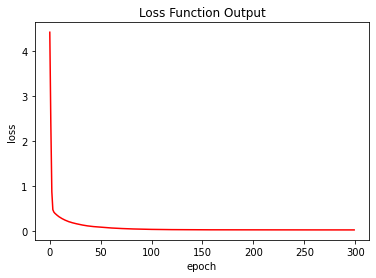

In [ ]:

results_train_loss = his.history['loss']
plt.plot(results_train_loss, color='red')
plt.title('Loss Function Output')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
model_orig.save('tp_1', '/home/daittan/NN-Repair/NN-Repair/')
import pickle

with open("/home/daittan/NN-Repair/NN-Repair/input_output_data_1.pickle", "wb") as data:
    pickle.dump([x_train, y_train, x_test, y_test], data)

INFO:tensorflow:Assets written to: tp_1/assets


#### Plot Trained Model Ouput

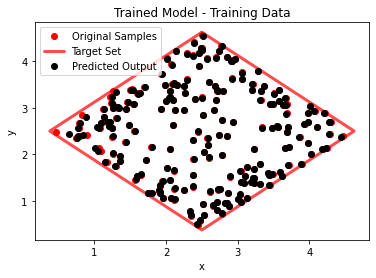

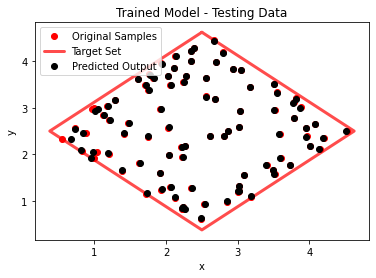

In [ ]:
def plot_model(model, x_true, y_true, poly_1, poly_2, arg):
    y_predict = model_orig.predict(x_true)
    
    ## training output
    plt.plot(y_true[:, 0], y_true[:, 1], 'ro', label='Original Samples')
    x_poly_2, y_poly_2 = poly_2.exterior.xy
    plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2,
             label='Target Set')

    ## predicted output
    plt.plot(y_predict[:, 0], y_predict[:, 1], 'ko', label='Predicted Output')
    plt.title(arg)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc="upper left")
    plt.show()
    return y_predict

y_predict_train = plot_model(model_orig, x_train, y_train, poly, poly2, arg='Trained Model - Training Data')
y_predict_test = plot_model(model_orig, x_test, y_test, poly, poly2, arg='Trained Model - Testing Data')